In [1]:
from __future__ import division

import json
from glob import glob
from tqdm import tqdm
import sys, os
import pandas as pd
import scanpy as sc
import scvelo as scv
import numpy as np
import scipy
from scipy import stats
import itertools
import warnings
from collections import OrderedDict 
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn

#plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

Global seed set to 0
/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
sys.path.append("utils/")
import utils as utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Plotting style
sc.settings.set_figure_params(dpi=120, fontsize=10, dpi_save=300, frameon=False, format='pdf')
sc.settings.verbosity = 0
sns.set_style(style="white")
sns.set_style("ticks")

**Define new cmap by truncating extreme colors, so the extremes are not so dark**

In [5]:
cmap = plt.get_cmap('RdYlBu_r')
new_cmap = utils.truncate_colormap(cmap, 0.1, 0.9)

# Load data

In [6]:
treatment_order = ['Intratracheal_RW', 'Intratracheal_N2']

In [7]:
adata = sc.read_h5ad("data/IT.proc.myeloid.h5ad")

# created a scaled layer
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X
adata.obs['treatment'] = adata.obs['treatment'].cat.reorder_categories(treatment_order)

**define cluster colors and set order**

In [8]:
cluster_colors = {k:v for k,v in zip(adata.obs['combined_clusters'].cat.categories, adata.uns['combined_clusters_colors'])}
cluster_colors

{'I4': '#029e73',
 'I3': '#d55e00',
 'I2': '#0173b2',
 'I1': '#de8f05',
 'M4': 'tab:purple',
 'M3': '#949494',
 'M2': '#ece133',
 'M1': '#cc78bc',
 'A2': '#56b4e9',
 'A1': '#fbafe4',
 'A3': '#ca9161'}

In [9]:
new_order_clusters = ['A1', 'A2', 'A3', 'I1', 'I2', 'I3', 'I4', 'M1', 'M2', 'M3', 'M4'][::-1]

adata.obs['combined_clusters'] = adata.obs['combined_clusters'].cat.reorder_categories(new_order_clusters)
adata.uns['combined_clusters_colors'] = [cluster_colors[el] for el in new_order_clusters]

**markers**

In [10]:
with open("data/IT_markers.json") as json_file:
    markers = json.load(json_file)

In [11]:
adata.obs['treatment'].unique()

['Intratracheal_N2', 'Intratracheal_RW']
Categories (2, object): ['Intratracheal_RW', 'Intratracheal_N2']

# Figure 4a

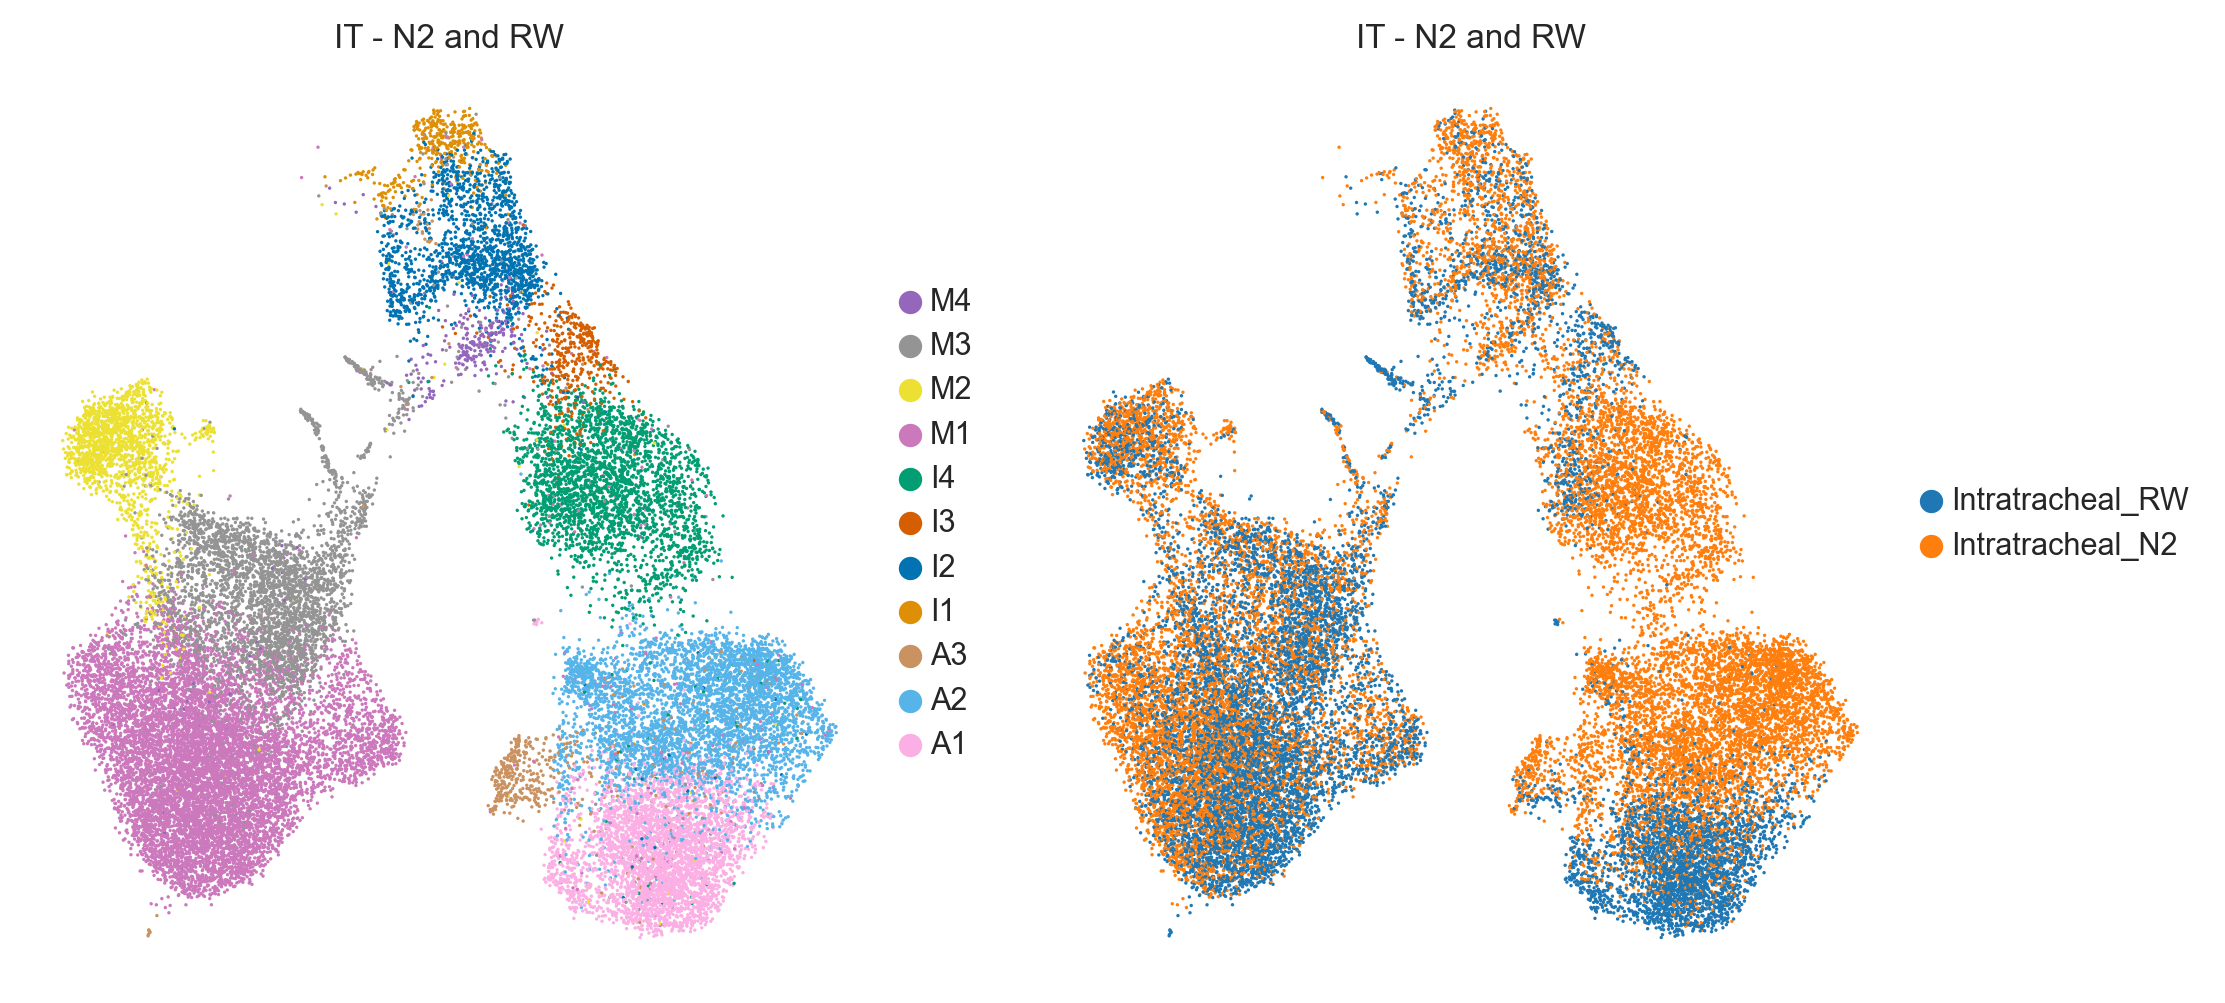

In [12]:
with plt.rc_context({"figure.figsize": (5, 4)}):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sc.pl.umap(adata, color='combined_clusters', title='IT - N2 and RW', show=False, ax=ax1)
    sc.pl.umap(adata, color='treatment', title='IT - N2 and RW', show=False, ax=ax2)

# Figure 4b

In [13]:
clusters = {
    'M':['M1', 'M2', 'M3', 'M4'],
    'I':['I1', 'I2', 'I3', 'I4'],
    'A':['A1', 'A2', 'A3']
}

colors = {}
for el in clusters:
    colors[el] = adata[adata.obs['combined_clusters'].isin(clusters[el])].uns['combined_clusters_colors']

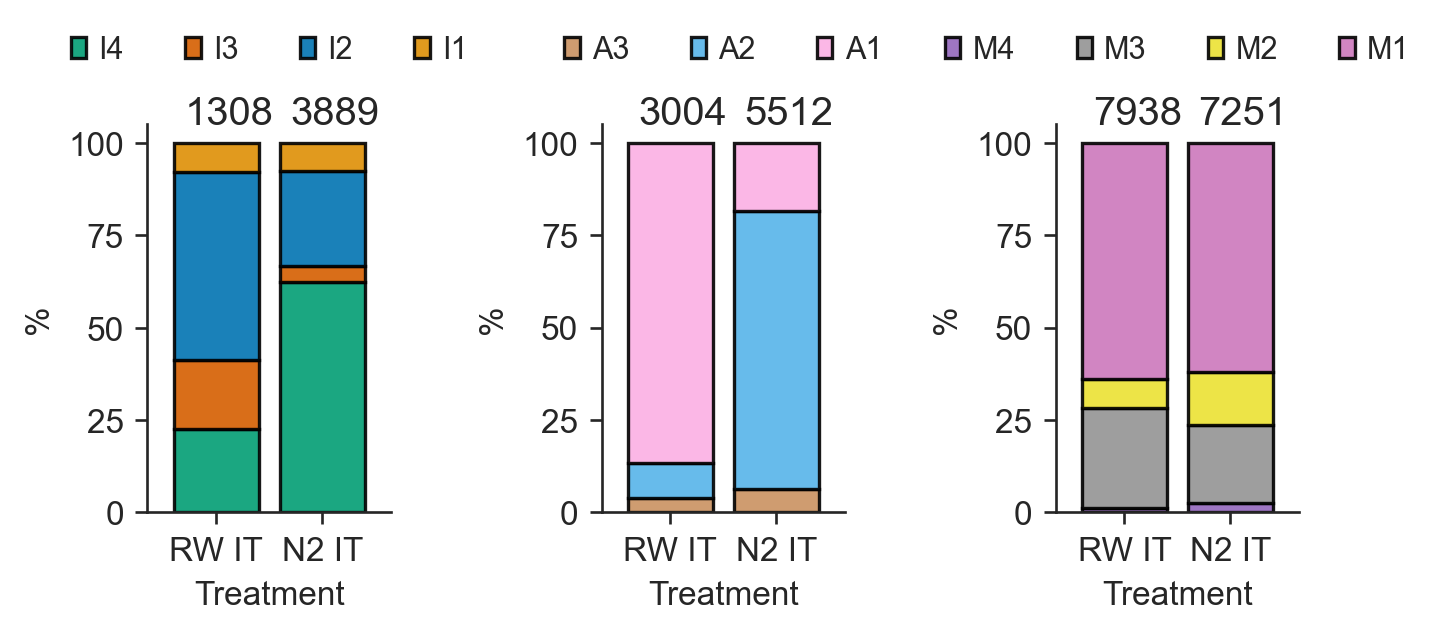

In [14]:
with plt.rc_context({ "font.size" : 12}):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(6, 3))

    utils.plotbarcomplete(adata[adata.obs['combined_clusters'].isin(clusters['I'])].obs, 'treatment', 'combined_clusters', #order_studies_simple,
                    colors['I'].tolist(), ax1,  order=treatment_order, kind='bar')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=10, frameon=False, )
    ax1.set_xticklabels(['RW IT', 'N2 IT'], rotation=0)
    ax1.set_ylabel('%')
    ax1.set_xlabel('Treatment')
    
    utils.plotbarcomplete(adata[adata.obs['combined_clusters'].isin(clusters['A'])].obs, 'treatment', 'combined_clusters', #order_studies_simple,
                    colors['A'].tolist(), ax2,  order=treatment_order, kind='bar')
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=10, frameon=False, )
    ax2.set_xticklabels(['RW IT', 'N2 IT'], rotation=0)
    ax2.set_ylabel('%')
    ax2.set_xlabel('Treatment')
    
    utils.plotbarcomplete(adata[adata.obs['combined_clusters'].isin(clusters['M'])].obs, 'treatment', 'combined_clusters', #order_studies_simple,
                    colors['M'].tolist(), ax3,  order=treatment_order, kind='bar')
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=10, frameon=False, )
    ax3.set_xticklabels(['RW IT', 'N2 IT'], rotation=0)
    ax3.set_ylabel('%')
    ax3.set_xlabel('Treatment')
    
    plt.tight_layout()

# Supplemental Figure 4a

**Recover zscored expression**

In [15]:
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['combined_clusters'].cat.categories) 

for clust in adata.obs.combined_clusters.cat.categories: 
    res.loc[clust] = adata[adata.obs['combined_clusters'].isin([clust]),:].layers['scaled'].mean(0)
    res = res.astype(float)

**Use zscored expression to refine markers**

In [16]:
# recover order for each cluster to improve image

order_clusters = []

for clus in markers:
    m = markers[clus]
    tmp = res[m]
    # Filter by expression
    m2 = tmp.T[[clus]]
    m2 = m2[m2>=0.7].dropna().drop_duplicates().index.tolist()
    # recover 'Lgals3', 'Cd9', 'Chil3', 'Itgax'
    if clus == 'I4':
        # Add markers that are important but get ranked lower
        m2 = m2 + ['Lgals3', 'Cd9', 'Chil3', 'Itgax']
    elif clus == 'A2':
        m2.insert(3, 'Cd63')
    tmp2 = res[m2]
    # update concise_markers
    markers[clus] = m2
    order_clusters+= utils.order_df_based_linkage(tmp2)

In [17]:
res = res[order_clusters]

In [18]:
map_genes = utils.map_genes_set(markers)
tmp = map_genes.pop('combined_clusters')
col_colors = tmp.map(cluster_colors).astype(str)

In [19]:
lens = {}
for c in ['I', 'A', 'M']:
    lens[c] = sum([len(markers[el]) for el in markers if c in el])

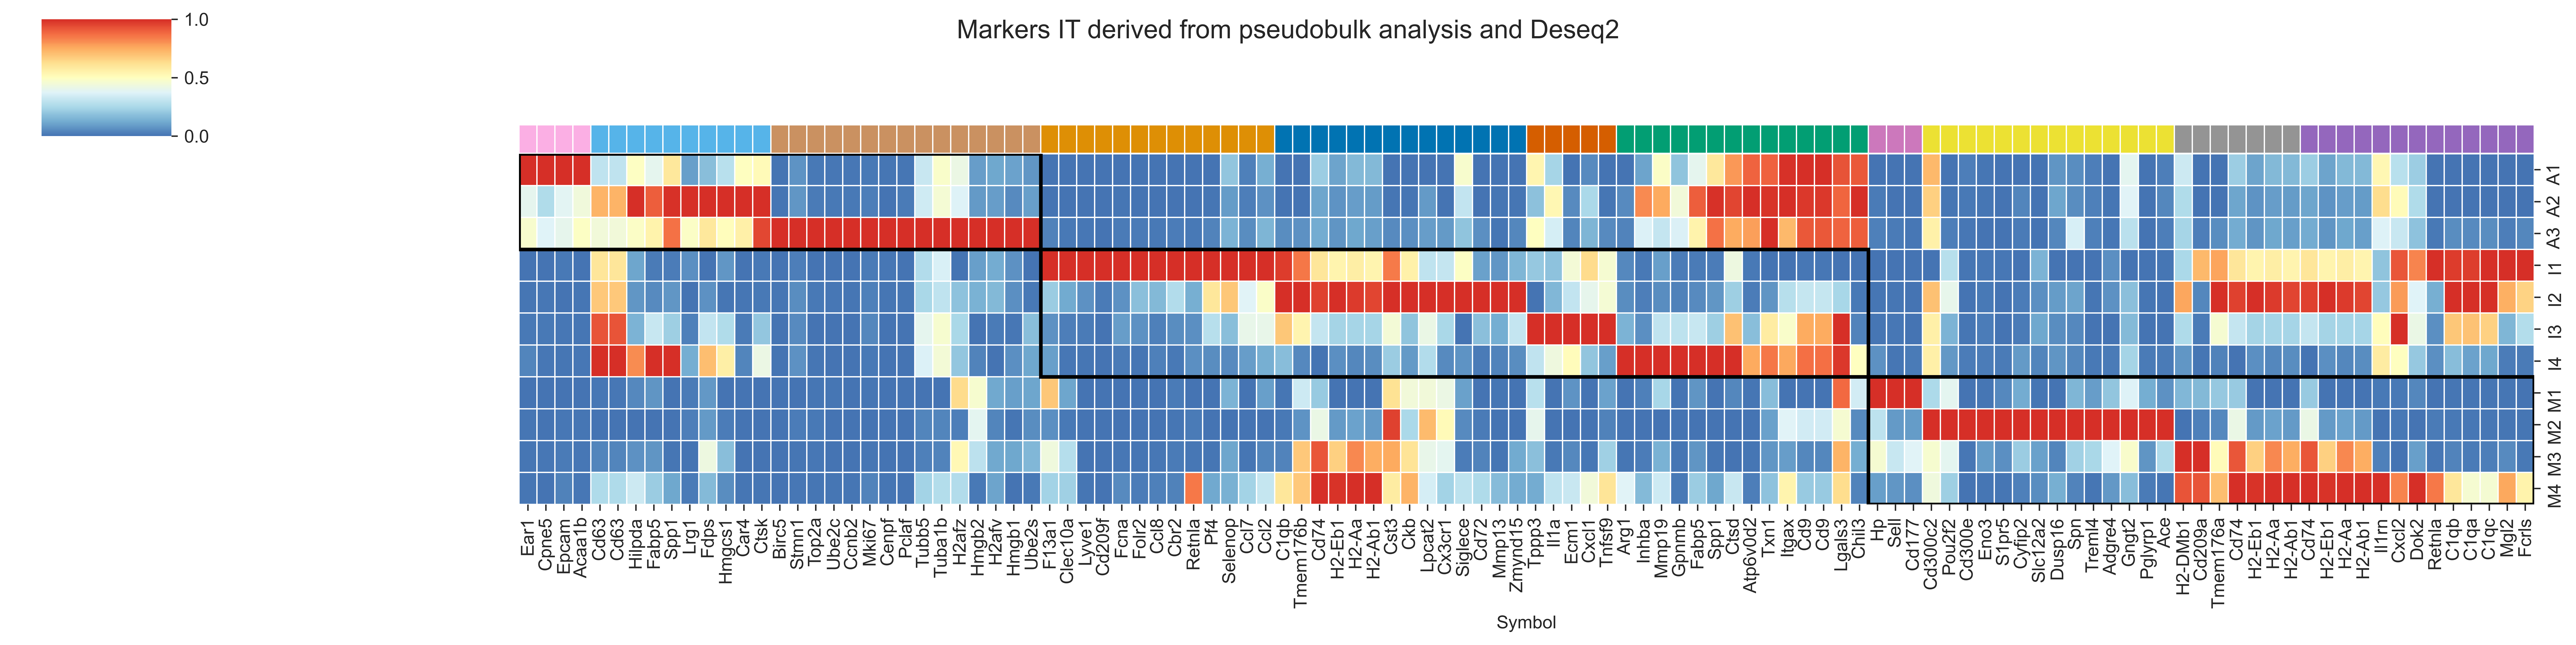

In [20]:
exp = 'IT'

with plt.rc_context({"figure.dpi": (300), "font.size" : 12}):
    f = sns.clustermap(res[::-1], figsize=(20, 5), row_cluster=False, col_cluster=False, cmap=new_cmap, standard_scale=1,
                    colors_ratio=0.06, linewidth=0.5, xticklabels=True, col_colors=col_colors.tolist())
    f.fig.suptitle(f'Markers {exp} derived from pseudobulk analysis and Deseq2')
    rect = patches.Rectangle((0, 0), lens['A'], 3, linewidth=2, edgecolor='black', facecolor='none')
    f.ax_heatmap.add_patch(rect)
    rect = patches.Rectangle((0+lens['A'], 3), lens['I'], 4, linewidth=2, edgecolor='black', facecolor='none')
    f.ax_heatmap.add_patch(rect)
    rect = patches.Rectangle((0+lens['A']+lens['I'], 7), lens['M'], 4, linewidth=2, edgecolor='black', facecolor='none')
    f.ax_heatmap.add_patch(rect)
    

# Figure 4e

In [21]:
cs = utils.cosine_similarity(adata, 'combined_clusters', 'X_pca')
cs['combined_clusters'] = cs.index.to_series().apply(lambda x:x[0])
cs['combined_clusters'] = cs['combined_clusters'].map({'M':'Mono', 'I':'IM', 'A':'AM'})
celltypes = cs.pop('combined_clusters')

In [22]:
lut = {'AM': '#1f77b4', 'IM': '#ff7f0e', 'Mono': '#279e68'}
row_colors = celltypes.map(lut)

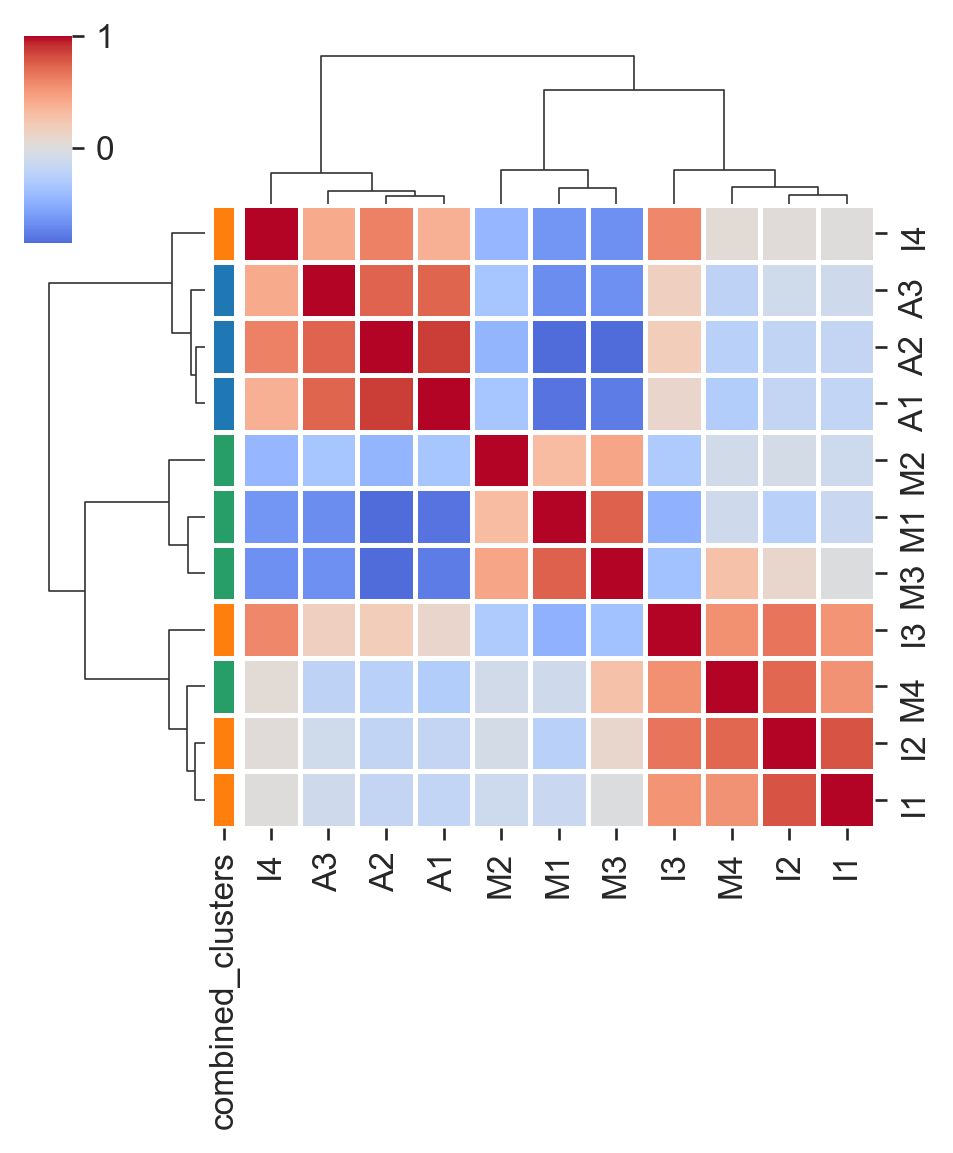

In [23]:
with plt.rc_context():
    f = sns.clustermap(cs, cmap="coolwarm", figsize=(4,4.8), linewidth=1, method='ward', center=0, row_colors=row_colors, xticklabels=True, yticklabels=True)

# Figure 4d

In [24]:
# Fix colors
adata.obs['SCN_class'] = adata.obs['SCN_class'].astype("category")
adata.obs['SCN_class'] = adata.obs['SCN_class'].cat.reorder_categories(
    ['I4', 'I3', 'I2', 'I1', 'M3', 'M2', 'M1', 'A2', 'A1', 'A3'] + ['rand'])

adata.uns['SCN_class_colors'] = ['#029e73', '#d55e00', '#0173b2', '#de8f05', 
                                        '#949494', '#ece133', '#cc78bc', '#56b4e9', '#fbafe4', '#ca9161', 'tab:red']

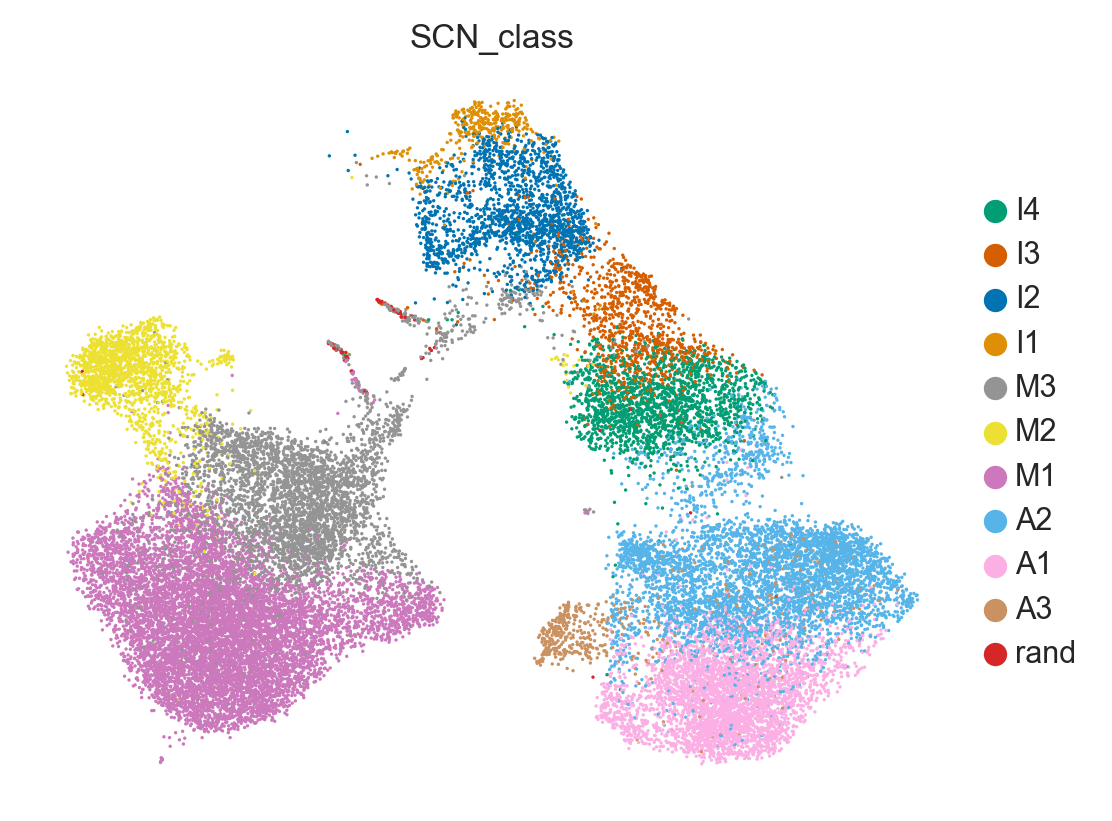

In [25]:
with plt.rc_context({"figure.figsize": (5, 4)}):
    f, ax = plt.subplots()
    sc.pl.umap(adata, color='SCN_class', show=False, ax=ax)

# Process for velocity

In [26]:
out_files = {}

out_files = {'IT_RW': 'data/IT_RWvel.h5ad',
             'IT_N2': 'data/IT_N2vel.h5ad'}

In [27]:
adatas = {}

for el in out_files:
    if os.path.exists(out_files[el]):
        print("Loading files")
        adatas[el] = sc.read_h5ad(out_files[el])
    else:
        split_by = "concise_annotation"
        adata = sc.read_h5ad("data/IT.proc.myeloid.h5ad")
        adatas[el] = adata[adata.obs[split_by]==el]
        adatas[el] = utils.basic_proc_for_velocity(adatas[el])
        adatas[el].write(out_files[el])


Loading files
Loading files


# Supplemental figure 4c

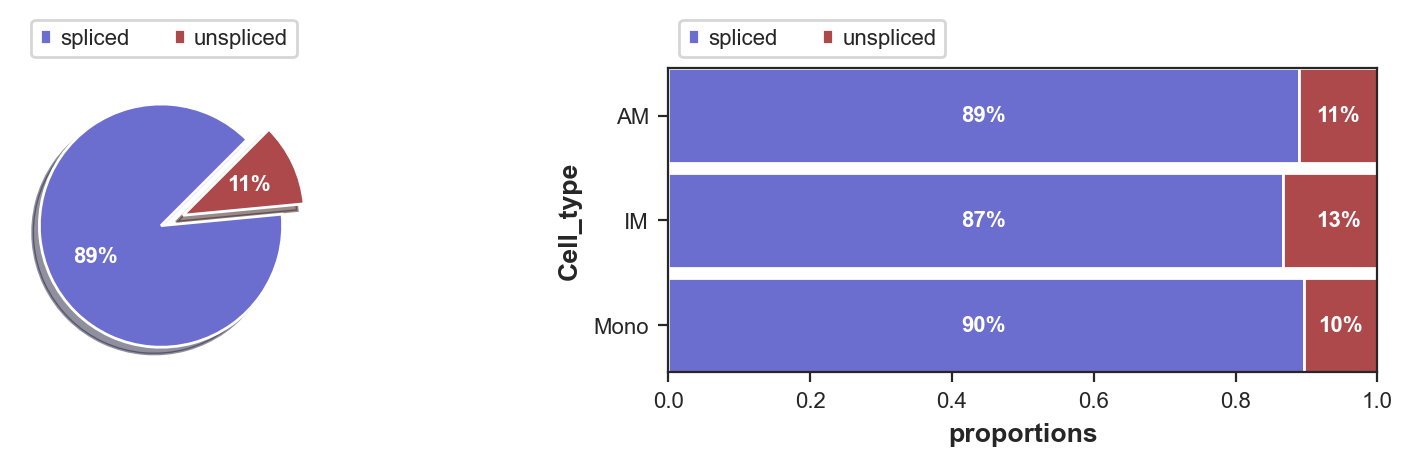

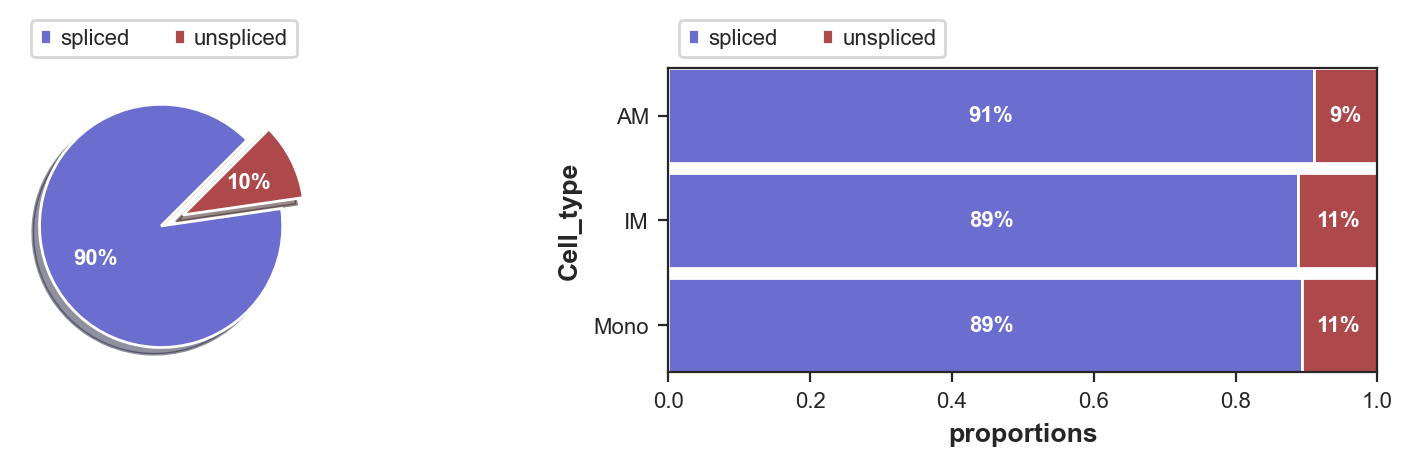

In [28]:
for el in adatas:
    scv.pl.proportions(adatas[el], groupby='Cell_type', layers=['spliced', 'unspliced'])

computing velocity embedding
    finished (0:00:06) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:07) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


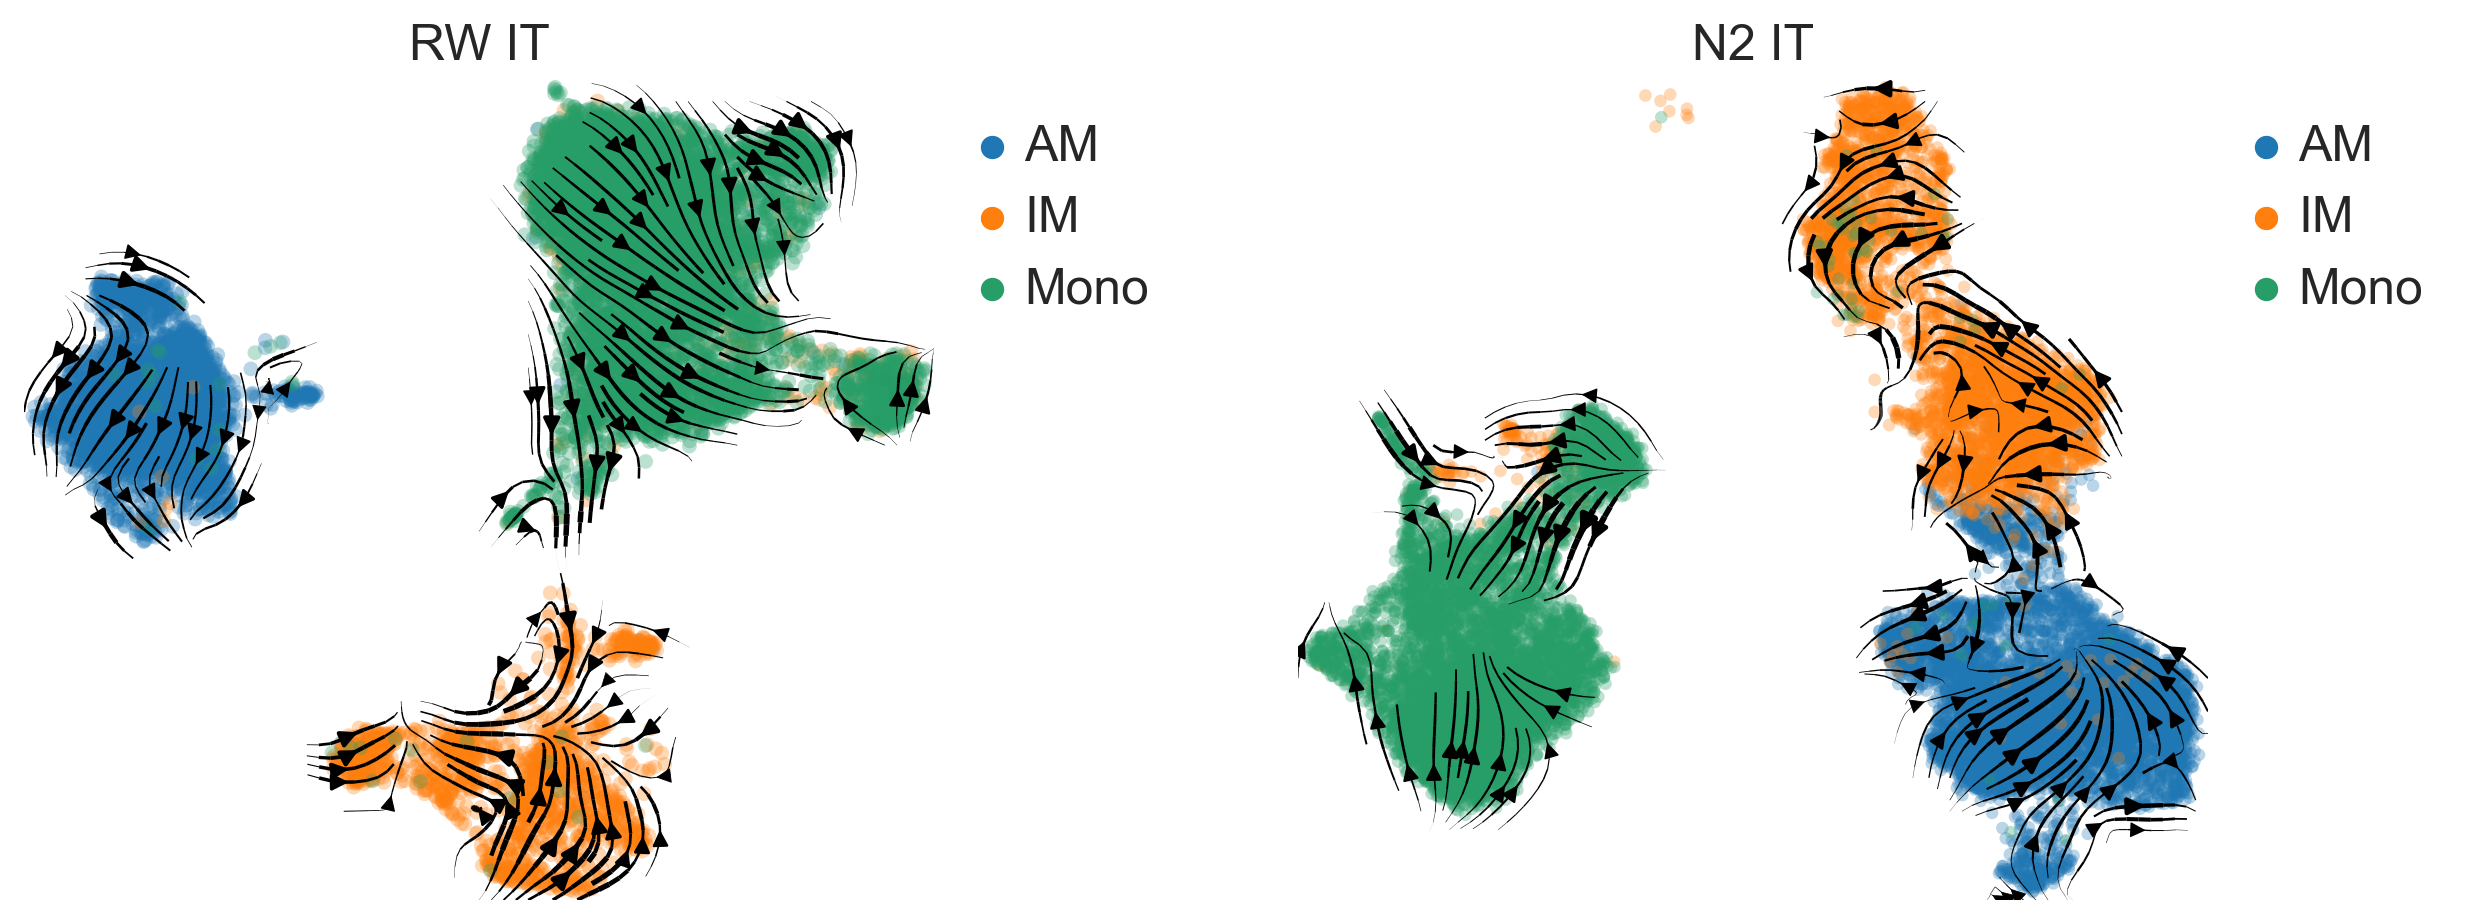

In [29]:
with plt.rc_context({"figure.figsize": (10, 5), "font.size" : 15}):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
    scv.pl.velocity_embedding_stream(adatas['IT_RW'], color='Cell_type', title='RW IT', density=2.5, show=False, 
                                     legend_loc='upper right', legend_fontsize=15, ax=ax1)
    scv.pl.velocity_embedding_stream(adatas['IT_N2'], color='Cell_type', title='N2 IT', density=2.5, show=False, 
                                     legend_loc='upper right', legend_fontsize=15, ax=ax2)
    f.subplots_adjust(wspace=0.4, left=0.05)

# Supplemental figure 4d

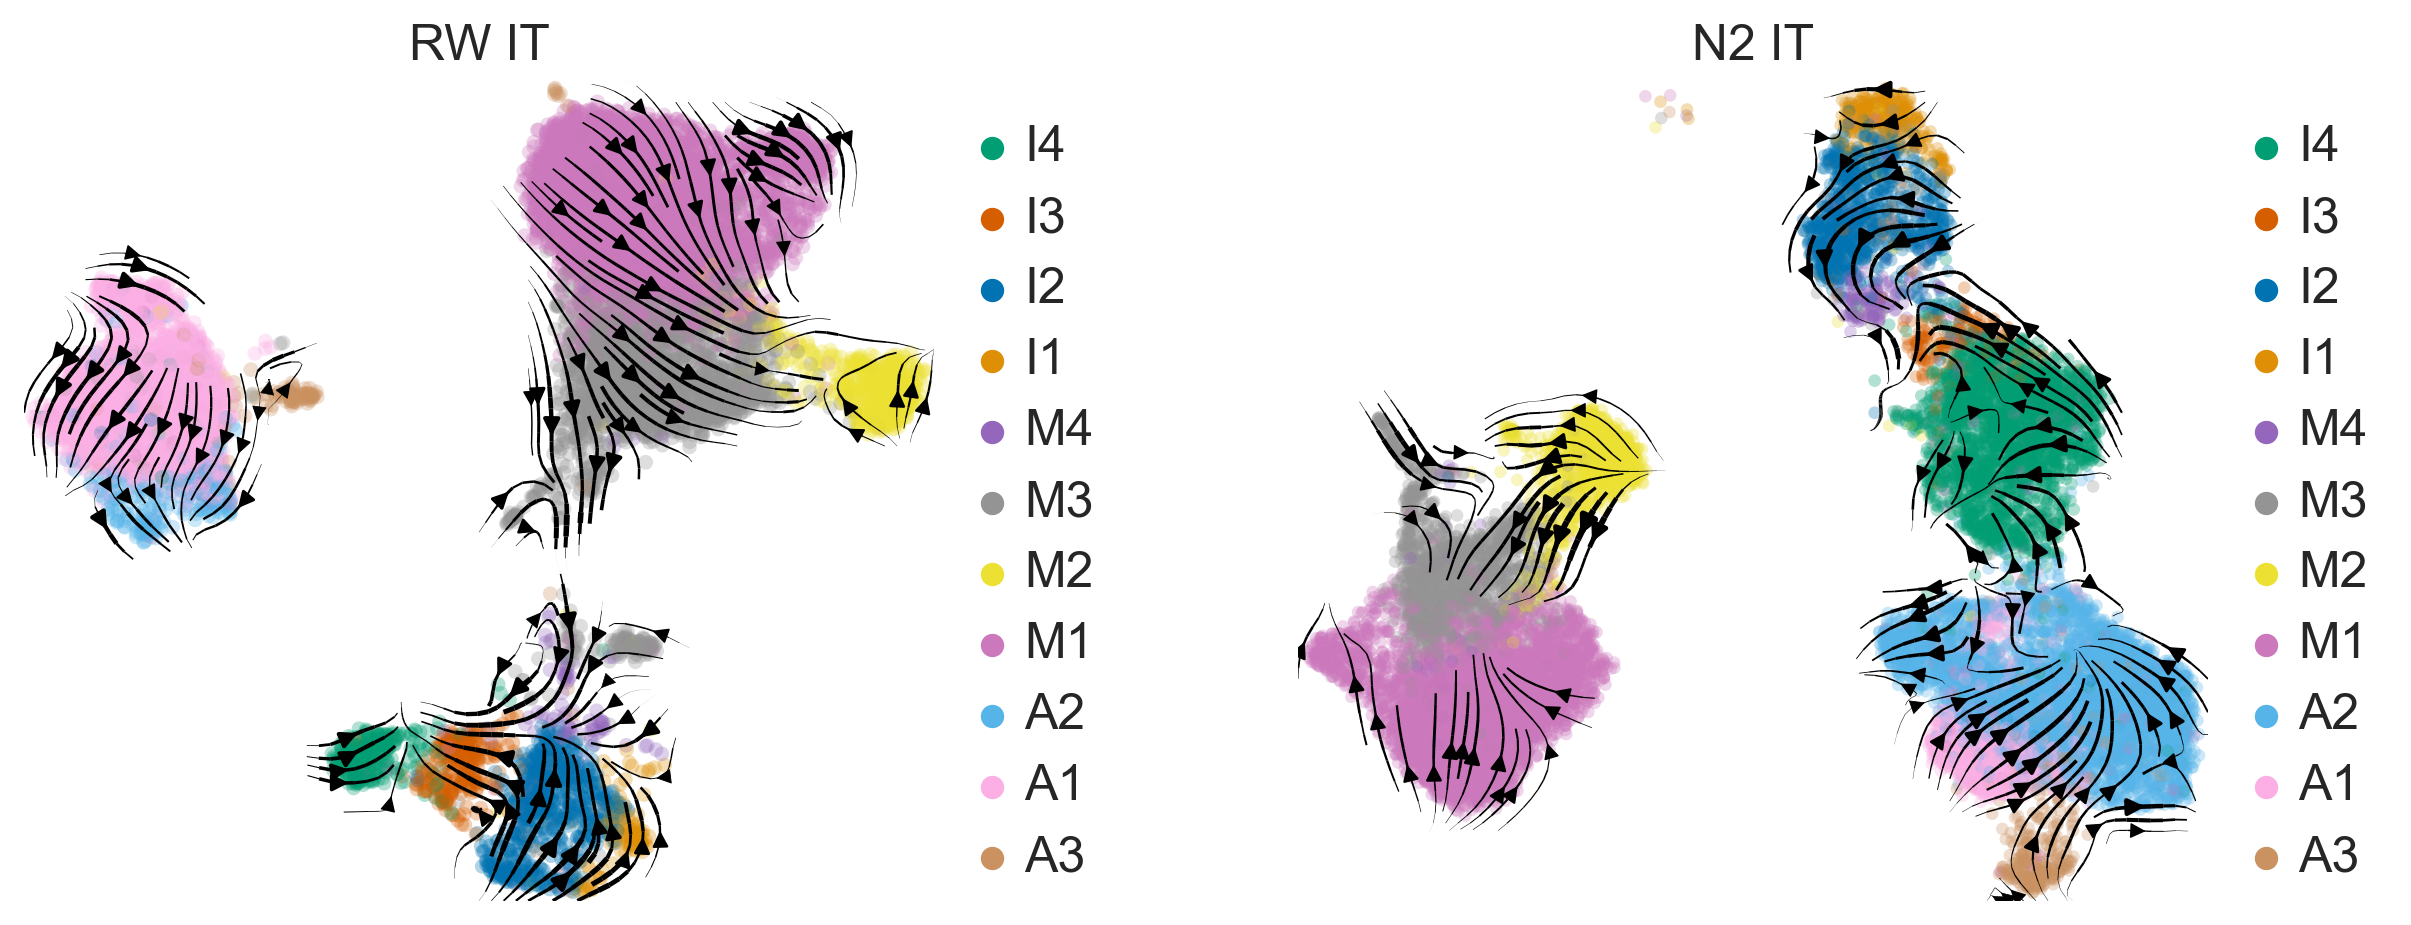

In [30]:
with plt.rc_context({"figure.figsize": (10, 5), "font.size" : 15}):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
    scv.pl.velocity_embedding_stream(adatas['IT_RW'], color='combined_clusters', title='RW IT', density=2.5, show=False, 
                                     legend_loc='upper right', legend_fontsize=15, ax=ax1)
    scv.pl.velocity_embedding_stream(adatas['IT_N2'], color='combined_clusters', title='N2 IT',  density=2.5, show=False,
                                     legend_loc='upper right', legend_fontsize=15, ax=ax2)
    f.subplots_adjust(wspace=0.4, left=0.05)
